In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.io import fits
from astropy.coordinates import SkyCoord
import astropy.units as u
import george
from george.modeling import Model
import healpy as hp
from healpy.newvisufunc import projview, newprojplot
import os
import sys
sys.path.insert(0, '/home/aew492/lss-dipoles')
from dipole import dipole_map, dipole, xyz_to_thetaphi
import tools

#### parameters for both selection function maps

In [4]:
mapdir = '/scratch/aew492/quasars/maps'
NSIDE = 64
G = 20.5

### selection function without dipole

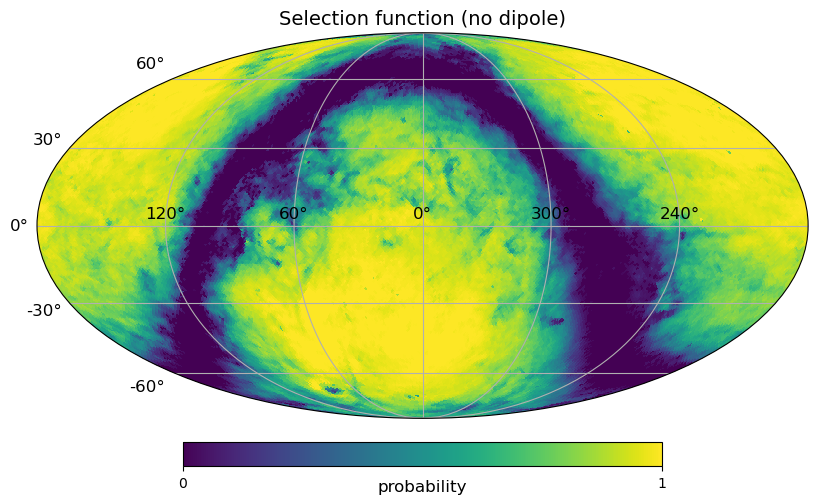

In [5]:
selfunc_nodip = tools.flatten_map(Table.read(os.path.join(mapdir,
                                    f'selection_function_NSIDE{NSIDE}_G{G}.fits'), format='fits'))
tools.plot_map(selfunc_nodip, title='Selection function (no dipole)', unit='probability')

### selection function with dipole

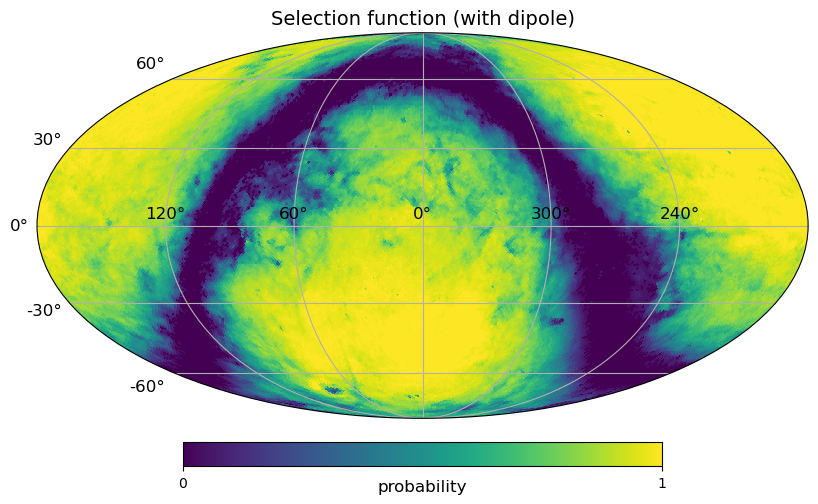

In [6]:
sf_fn = f'selection_function_NSIDE{NSIDE}_G{G}_dipole'
selfunc_dip = tools.flatten_map(Table.read(os.path.join(mapdir, f'{sf_fn}.fits'), format='fits'))
tools.plot_map(selfunc_dip, title='Selection function (with dipole)', unit='probability')

### residuals

In [7]:
res = selfunc_dip / selfunc_nodip

/state/partition1/job-35449835/ipykernel_1067110/1014798161.py:1: RuntimeWarning: invalid value encountered in divide
  res = selfunc_dip / selfunc_nodip


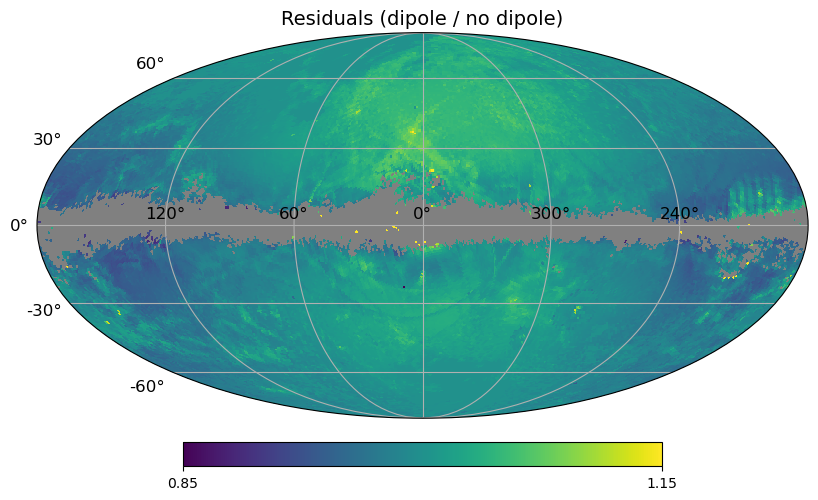

In [8]:
tools.plot_map(res, title='Residuals (dipole / no dipole)', min=0.85, max=1.15, coord=['C','G'])

### recovered dipole

In [23]:
# check dipole optimization result
result = np.load(os.path.join(mapdir, f'{sf_fn}-res.npy'), allow_pickle=True).item()
result

  message: Maximum number of iterations has been exceeded.
  success: False
   status: 1
      fun: -5644.2111695405765
        x: [ 1.786e+00 -2.174e-02 -5.262e-02 -2.956e-02 -2.510e-01
             1.698e+00 -2.816e+00  4.918e+00]
      nit: 15
      jac: [-5.823e-04  5.071e-02 -1.184e-03  1.282e-02  5.269e-03
            -1.768e-03  1.433e-03 -1.493e-03]
 hess_inv: [[ 6.144e-02 -3.055e-07 ... -1.250e-03 -5.294e-03]
            [-3.055e-07  2.117e-06 ... -3.539e-06  8.224e-06]
            ...
            [-1.250e-03 -3.539e-06 ...  2.225e-02 -5.978e-03]
            [-5.294e-03  8.224e-06 ... -5.978e-03  2.553e-01]]
     nfev: 25
     njev: 25

In [24]:
amps_quaia = result.x[:4]
amps_quaia

array([ 1.78632923, -0.02173502, -0.05261658, -0.02955998])

In [25]:
# amplitude and direction
dipoleamp = np.linalg.norm(amps_quaia[1:])
print(f"dipole amplitude = {dipoleamp:.6f}")
theta, phi = xyz_to_thetaphi(amps_quaia[1:])*u.radian
print(f"\ntheta = {theta:.4f}, phi = {phi:.4f} --> theta = {theta.to('deg'):.2f}, phi = {phi.to('deg'):.2f}")
print("in equatorial coordinates!")

dipole amplitude = 0.064146

theta = 2.0497 rad, phi = -1.9625 rad --> theta = 117.44 deg, phi = -112.44 deg
in equatorial coordinates!


In [26]:
# SkyCoord takes in (LON,LAT), with LAT=0 at the equator
dip_quaia = SkyCoord(phi, np.pi/2*u.rad-theta, unit=u.rad, frame='icrs')
print(dip_quaia)

<SkyCoord (ICRS): (ra, dec) in deg
    (247.55530364, -27.44025667)>


In [27]:
# CMB dipole (from Planck2020)
dip_cmb = SkyCoord(264.021, 48.253, unit=u.deg, frame='galactic')
print(dip_cmb)
print(dip_cmb.icrs)

<SkyCoord (Galactic): (l, b) in deg
    (264.021, 48.253)>
<SkyCoord (ICRS): (ra, dec) in deg
    (167.94190333, -6.94425998)>


In [28]:
# Secrest dipole
dip_secrest = SkyCoord(238.2, 28.8, unit=u.deg, frame='galactic')
print(dip_secrest)
print(dip_secrest.icrs)

<SkyCoord (Galactic): (l, b) in deg
    (238.2, 28.8)>
<SkyCoord (ICRS): (ra, dec) in deg
    (139.95872689, -6.5016976)>


QUaia dipole:  <SkyCoord (ICRS): (ra, dec) in deg
    (247.55530364, -27.44025667)>
QUaia (theta, phi) = (2.05 rad, -1.96 rad)
monopole, dipole amps:  [ 1.78632923 -0.02173502 -0.05261658 -0.02955998]
dipole amplitude = 0.06415

CMB dipole:  <SkyCoord (ICRS): (ra, dec) in deg
    (167.94190333, -6.94425998)>
CMB (phi, theta) = (2.93 rad, 1.45 rad)
dipole amplitude ~ 0.007

S21 dipole:  <SkyCoord (ICRS): (ra, dec) in deg
    (139.95872689, -6.5016976)>
S21 (phi, theta) = (2.44 rad, 1.46 rad)
dipole amplitude  = 0.01554

xyz axes:
[1. 0. 0.], (theta, phi) = (1.57 rad, 0.00 rad)
[0. 1. 0.], (theta, phi) = (1.57 rad, 1.57 rad)
[0. 0. 1.], (theta, phi) = (0.00 rad, 0.00 rad)


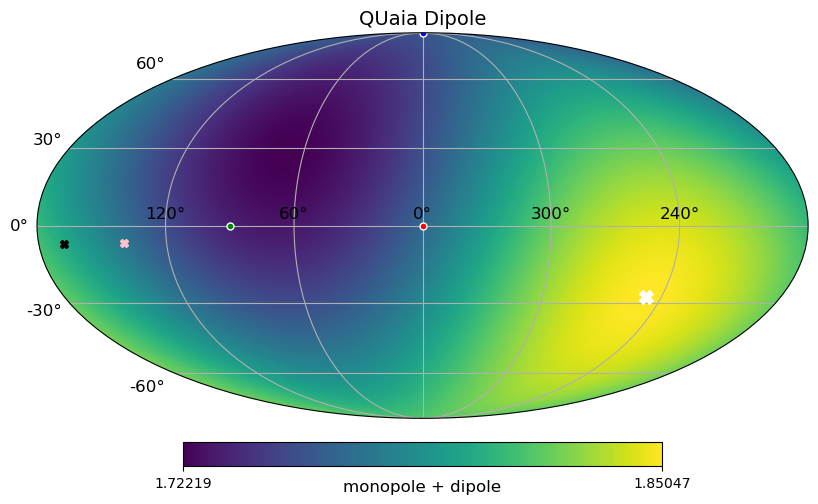

In [30]:
# QUaia dipole
projview(dipole_map(amps_quaia), projection_type='mollweide',
        graticule=True, graticule_labels=True, title='QUaia Dipole', unit='monopole + dipole')
print("QUaia dipole: ", dip_quaia.icrs)
theta_quaia, phi_quaia = xyz_to_thetaphi(amps_quaia[1:])*u.radian
print(f"QUaia (theta, phi) = ({theta_quaia:.2f}, {phi_quaia:.2f})")
print("monopole, dipole amps: ", amps_quaia)
print(f"dipole amplitude = {dipoleamp:.5f}")
newprojplot(theta_quaia, phi_quaia, marker='X', color='white', ms=10, label='QUaia')

# CMB dipole
print("\nCMB dipole: ", dip_cmb.icrs)
print(f"CMB (phi, theta) = ({dip_cmb.icrs.ra.to('rad'):.2f}, {dip_cmb.icrs.dec.to('rad')+np.pi/2*u.rad:.2f})")
print("dipole amplitude ~ 0.007")
newprojplot(np.pi/2-dip_cmb.icrs.dec.rad, dip_cmb.icrs.ra.rad, marker='X', color='k', label='CMB')

# Secrest dipole
print("\nS21 dipole: ", dip_secrest.icrs)
print(f"S21 (phi, theta) = ({dip_secrest.icrs.ra.to('rad'):.2f}, {dip_secrest.icrs.dec.to('rad')+np.pi/2*u.rad:.2f})")
print("dipole amplitude  = 0.01554")
newprojplot(np.pi/2-dip_secrest.icrs.dec.rad, dip_secrest.icrs.ra.rad, marker='X', color='pink', label='S21')

# plot (x,y,z) axes for reference
print("\nxyz axes:")
cs = ['r', 'g', 'b']
for i, unit_vec in enumerate(np.identity(3)):
    theta, phi = xyz_to_thetaphi(unit_vec)*u.radian
    print(f"{unit_vec}, (theta, phi) = ({theta:.2f}, {phi:.2f})")
    newprojplot(theta, phi, marker='.', color=cs[i], ms=10, markeredgecolor='white')

QUaia dipole:  <SkyCoord (Galactic): (l, b) in deg
    (351.28967104, 14.26126745)>
QUaia (theta, phi) = (2.05 rad, -1.96 rad)
monopole, dipole amps:  [ 1.78632923 -0.02173502 -0.05261658 -0.02955998]
dipole amplitude = 0.06415

CMB dipole:  <SkyCoord (Galactic): (l, b) in deg
    (264.021, 48.253)>
dipole amplitude ~ 0.007

S21 dipole:  <SkyCoord (Galactic): (l, b) in deg
    (238.2, 28.8)>
dipole amplitude  = 0.01554

xyz axes:
[1. 0. 0.], (theta, phi) = (1.57 rad, 0.00 rad)
[0. 1. 0.], (theta, phi) = (1.57 rad, 1.57 rad)
[0. 0. 1.], (theta, phi) = (0.00 rad, 0.00 rad)


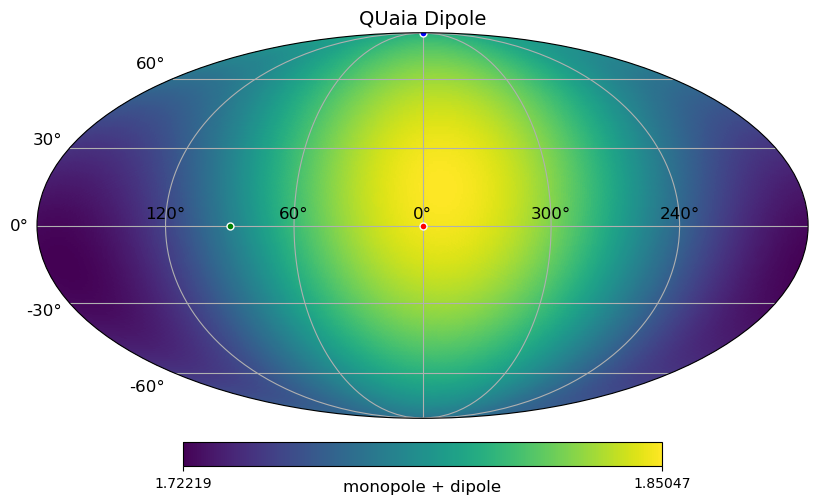

In [32]:
# QUaia dipole
projview(dipole_map(amps_quaia), projection_type='mollweide',
        graticule=True, graticule_labels=True, title='QUaia Dipole', unit='monopole + dipole', coord=['C','G'])
print("QUaia dipole: ", dip_quaia.galactic)
theta_quaia, phi_quaia = xyz_to_thetaphi(amps_quaia[1:])*u.radian
print(f"QUaia (theta, phi) = ({theta_quaia:.2f}, {phi_quaia:.2f})")
print("monopole, dipole amps: ", amps_quaia)
print(f"dipole amplitude = {dipoleamp:.5f}")

newprojplot(np.pi/2-dip_quaia.galactic.b.rad, dip_quaia.galactic.l.rad, marker='X', color='white', ms=10, label='QUaia')

# CMB dipole
print("\nCMB dipole: ", dip_cmb.galactic)
print("dipole amplitude ~ 0.007")
newprojplot(np.pi/2-dip_cmb.galactic.b.rad, dip_cmb.galactic.l.rad, marker='X', color='k', label='CMB')
newprojplot()

# Secrest dipole
print("\nS21 dipole: ", dip_secrest.galactic)
print("dipole amplitude  = 0.01554")
newprojplot(np.pi/2-dip_secrest.galactic.b.rad, dip_secrest.galactic.l.rad, marker='X', color='pink', label='S21')

# plot (x,y,z) axes for reference
print("\nxyz axes:")
cs = ['r', 'g', 'b']
for i, unit_vec in enumerate(np.identity(3)):
    theta, phi = xyz_to_thetaphi(unit_vec)*u.radian
    print(f"{unit_vec}, (theta, phi) = ({theta:.2f}, {phi:.2f})")
    newprojplot(theta, phi, marker='.', color=cs[i], ms=10, markeredgecolor='white')